<a href="https://colab.research.google.com/github/rishi-a/Twitter-AQ/blob/master/Hypothesis%201/Classifier_with_BERT_senti140.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Another implementation 

In [ ]:
import numpy as np
import pandas as pd
import torch
!pip install transformers
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 573kB 4.7MB/s 
     |████████████████████████████████| 890kB 13.0MB/s 
     |████████████████████████████████| 3.7MB 21.8MB/s 
     |████████████████████████████████| 1.0MB 44.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=88b0e0cdcf4e624b6107b39ecaeca5bdde3fd2e9307eda0709ff97e3ac3f6442
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
train = pd.read_csv('OddEvenUnique - OddEvenUnique (1).csv')
train = train[train['ZLabel'].notna()]
train = train[:-1]
train.shape

(800, 14)

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
train.tweet.str.len().max()
def preprocess(tweet):
  #tweet = tweet.replace('@ ','@').replace('# ','#')
  return ' '.join(w for w in tweet.split() if w[0] not in ['@'] and 
                  not w.startswith('pic.twitter.com') and
                  not w.startswith('http://') and
                  not w.startswith('https://')).lower()
train['tweet'] = train['tweet'].apply(preprocess)

In [ ]:
tokenized = train['tweet'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(800, 122)

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(800, 122)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import pickle 
dict1 = pd.read_pickle('/content/gdrive/My Drive/800OE-S140')
features = (dict1['layers'][:,:]).numpy()
labels = np.array(dict1['labels'])

In [ ]:
features.shape

(800, 768)

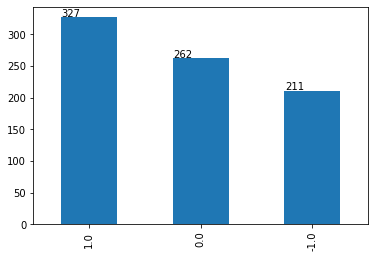

In [ ]:
df = pd.DataFrame(columns=['labels'])
df['labels'] = labels
ax = df['labels'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##LR

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from matplotlib import pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
#pd.set_option('display.max_colwidth', 2000) # To visualize full output
pd.set_option("display.max_rows", None, "display.max_columns", None)

Using TensorFlow backend.


In [ ]:
from itertools import product
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score

def create_model(C, penalty):
	# create model:
  nb = LogisticRegression(C = C ,penalty = penalty,solver='liblinear',fit_intercept= True)
  return nb

def GridSearchCV(X, y, train_val_index, y_train_val, param_grid):
  hyperpara_dict = {}
  
  kfInner = StratifiedKFold(5, shuffle=True, random_state=0)
  train_ind, val_ind = next(kfInner.split(train_val_index, y_train_val))
  train_df_ind = train_val_index[train_ind]
  val_df_ind = train_val_index[val_ind]
  X_train, y_train = X[train_df_ind], y[train_df_ind]
  X_val, y_val = X[val_df_ind], y[val_df_ind]
  #smt = SMOTE(random_state=0)
  #XXX, yyy = smt.fit_resample(X_train, y_train)
  for C, penalty in product(*param_grid.values()):
    model = create_model(C, penalty)
    model.fit(X_train,y_train)
    res = model.predict(X_val)
    score = pd.DataFrame(res)
    y_pred = pd.DataFrame(res)
    accuracy = f1_score(y_val, y_pred, average='macro')
    hyperpara_dict.update({(C,penalty) : accuracy})
  return max(hyperpara_dict, key=lambda x: hyperpara_dict[x])

In [ ]:
X = features
y = labels
parameters = {'C': [0.01,0.1,10,100],
              'penalty': ('l1', 'l2')}

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold()
test_inds = []
test_preds = []
test = []
score = []
for train_val_index, test_index in kf.split(X, y):
  X_train_val, X_test = X[train_val_index], X[test_index]
  y_train_val, y_test = y[train_val_index], y[test_index]
  C, penalty = GridSearchCV(X, y, train_val_index, y_train_val, parameters)
  print('best', C,penalty)
  model = create_model(C,penalty)
  #smt = SMOTE(random_state=0)
  #XXX, yyy = smt.fit_resample(X_train_val, y_train_val)
  model.fit(X_train_val, y_train_val)
  res = model.predict(X_test)
  sc = model.predict_proba(X_test)
  sc = pd.DataFrame(sc).max(axis =1)
  y_pred = res
  accuracy = f1_score(y_test, y_pred, average='macro')
  print(accuracy)
  test_inds.extend(test_index)
  test_preds.extend(y_pred)
  test.extend(y_test)
  score.extend(sc)

best 5.263252631578947 l1
0.523647544789492
best 15.789557894736841 l1
0.4825708674062515
best 21.05271052631579 l2
0.633080808080808
best 31.579015789473683 l2
0.5598368734069669
best 21.05271052631579 l1
0.541313674673868


              precision    recall  f1-score   support

           0       0.51      0.52      0.51       211
           1       0.51      0.54      0.52       262
           2       0.63      0.59      0.61       327

    accuracy                           0.56       800
   macro avg       0.55      0.55      0.55       800
weighted avg       0.56      0.56      0.56       800



Text(33.0, 0.5, 'ground truth')

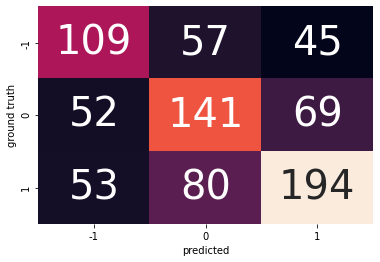

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
print(classification_report(test, test_preds))
sns.heatmap((confusion_matrix(test,test_preds)),annot=True,annot_kws={"size": 40},cbar=False,fmt='g',
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])


plt.xlabel('predicted')
plt.ylabel('ground truth')

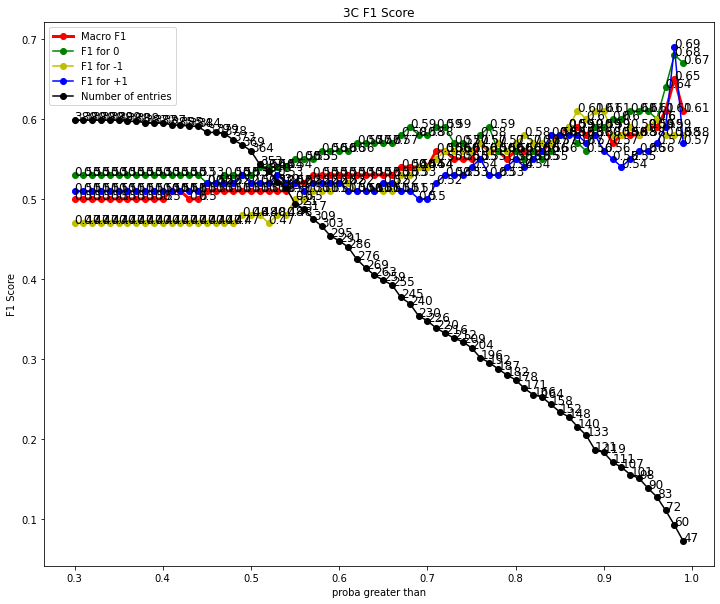

0.65
0.9800000000000006
60


In [ ]:
df = pd.DataFrame(columns=['ZLabel', 'pred', 'score'])
df['ZLabel'] = test
df['pred'] = test_preds
df['score'] = score
#result.to_csv('3nbmogwithoutfinal.csv')

x = []
y = []
y0 = []
y1 = []
y2 = []
N = []
for i in np.arange(3,10,0.1):
    x.append(i/10)
    ddata = df[df['score'] >= i*0.1]
    N.append(len(ddata))
    y.append(round(f1_score(ddata['ZLabel'], ddata['pred'], average='macro'),2))
    y0.append(round(f1_score(ddata['ZLabel'], ddata['pred'], average=None)[0],2))
    y1.append(round(f1_score(ddata['ZLabel'], ddata['pred'], average=None)[1],2))
    y2.append(round(f1_score(ddata['ZLabel'], ddata['pred'], average=None)[2],2))
plt.figure(figsize=(12,10))
plt.plot(x, y, 'ro-', label='Macro F1', linewidth=3)

plt.plot(x, y1, 'go-', label='F1 for 0')
plt.plot(x, y0, 'yo-', label='F1 for -1')
plt.plot(x, y2, 'bo-', label='F1 for +1')
plt.plot(x, np.array(N)/650, 'ko-', label='Number of entries')

def annotate(x, y):
    for xx, yy in zip(x, y):
        plt.annotate(str(yy),(xx, yy),size=12)
annotate(x, y)
annotate(x, y0)
annotate(x, y1)
annotate(x, y2)
for xx, yy in zip(x, np.array(N)):
        plt.annotate(str(yy),(xx, yy/650),size=12)
plt.ylabel('F1 Score')
plt.xlabel('proba greater than')
plt.title('3C F1 Score')
plt.legend()
plt.show()
index_max = np.argmax(y)
print(max(y))
print(x[index_max])
print(N[index_max])

##SVC RBF

In [ ]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from matplotlib import pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
#pd.set_option('display.max_colwidth', 2000) # To visualize full output
pd.set_option("display.max_rows", None, "display.max_columns", None)

Using TensorFlow backend.


In [ ]:
from itertools import product
from sklearn.metrics import balanced_accuracy_score

def create_model(C,gamma):
	# create model:
  nb = SVC(C = C, gamma = gamma,probability= True )
  return nb

def GridSearchCV(X, y, train_val_index, y_train_val, param_grid):
  hyperpara_dict = {}
  
  kfInner = StratifiedKFold(5, shuffle=True, random_state=0)
  train_ind, val_ind = next(kfInner.split(train_val_index, y_train_val))
  train_df_ind = train_val_index[train_ind]
  val_df_ind = train_val_index[val_ind]
  X_train, y_train = X[train_df_ind], y.iloc[train_df_ind]
  X_val, y_val = X[val_df_ind], y.iloc[val_df_ind]
  #smt = SMOTE(random_state=0)
  #XXX, yyy = smt.fit_resample(X_train, y_train)
  for C,gamma in product(*param_grid.values()):
    model = create_model(C,gamma)
    model.fit(X_train,y_train)
    res = model.predict(X_val)
    score = pd.DataFrame(res)
    y_pred = pd.DataFrame(res)
    accuracy = f1_score(y_val, y_pred, average='macro')
    hyperpara_dict.update({(C,gamma) : accuracy})
  return max(hyperpara_dict, key=lambda x: hyperpara_dict[x])

In [ ]:
# Main code
from sklearn.model_selection import train_test_split
#df_main.loc[df_main['ZLabel'] == -1, 'ZLabel'] = 0
#df_main.loc[df_main['ZLabel'] == -1, 'ZLabel'] = 0
y = labels
X = features

tuned_parameters = {
                    'gamma': [0.01.0.001,0.0001],
                     'C': [0.01,0.1,10,100] }

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold()
test_inds = []
test_preds = []
test = []
score = []
for train_val_index, test_index in kf.split(X, y):
  X_train_val, X_test = X[train_val_index], X[test_index]
  y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
  C,gamma = GridSearchCV(X, y, train_val_index, y_train_val, tuned_parameters)
  print('best',C,gamma)
  model = create_model(C,gamma)
  #smt = SMOTE(random_state=0)
  #XXX, yyy = smt.fit_resample(X_train_val, y_train_val)
  model.fit(X_train_val, y_train_val)
  res = model.predict(X_test)
  sc = model.predict_proba(X_test)
  sc = pd.DataFrame(sc).max(axis =1)
  y_pred = res
  accuracy = f1_score(y_test, y_pred, average='macro')
  print(accuracy)
  test_inds.extend(test_index)
  test_preds.extend(y_pred)
  test.extend(y_test)
  score.extend(sc)

best 0.001 1
0.18068535825545173
best 0.001 1
0.1761006289308176
best 0.001 1
0.1761006289308176
best 0.001 1
0.1761006289308176
best 0.001 1
0.17777777777777778


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       119
         0.0       0.36      1.00      0.53       141
         1.0       0.00      0.00      0.00       129

    accuracy                           0.36       389
   macro avg       0.12      0.33      0.18       389
weighted avg       0.13      0.36      0.19       389



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(33.0, 0.5, 'ground truth')

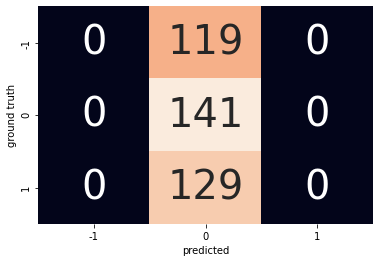

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

print(classification_report(test, test_preds))
sns.heatmap((confusion_matrix(test,test_preds)),annot=True,annot_kws={"size": 40},cbar=False,fmt='g',
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])


plt.xlabel('predicted')
plt.ylabel('ground truth')

##SVC Polynomial

In [ ]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from matplotlib import pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
#pd.set_option('display.max_colwidth', 2000) # To visualize full output
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
from itertools import product
from sklearn.metrics import balanced_accuracy_score

def create_model(C,gamma,degree):
	# create model:
  nb = SVC(kernel = 'poly',C = C, gamma = gamma,probability= True,degree = degree )
  return nb

def GridSearchCV(X, y, train_val_index, y_train_val, param_grid):
  hyperpara_dict = {}
  
  kfInner = StratifiedKFold(5, shuffle=True, random_state=0)
  train_ind, val_ind = next(kfInner.split(train_val_index, y_train_val))
  train_df_ind = train_val_index[train_ind]
  val_df_ind = train_val_index[val_ind]
  X_train, y_train = X[train_df_ind], y[train_df_ind]
  X_val, y_val = X[val_df_ind], y[val_df_ind]
  #smt = SMOTE(random_state=0)
  #XXX, yyy = smt.fit_resample(X_train, y_train)
  for C,gamma,degree in product(*param_grid.values()):
    model = create_model(C,gamma,degree)
    model.fit(X_train,y_train)
    res = model.predict(X_val)
    score = pd.DataFrame(res)
    y_pred = pd.DataFrame(res)
    accuracy = f1_score(y_val, y_pred, average='macro')
    hyperpara_dict.update({(C,gamma,degree) : accuracy})
  return max(hyperpara_dict, key=lambda x: hyperpara_dict[x])

In [ ]:
# Main code
from sklearn.model_selection import train_test_split
#df_main.loc[df_main['ZLabel'] == -1, 'ZLabel'] = 0
#df_main.loc[df_main['ZLabel'] == -1, 'ZLabel'] = 0
y = labels
X = features

tuned_parameters = {
                    'gamma': [0.01,0.001,0.0001],
                     'C': [0.001,0.1, 10, 100] ,
                      'degree': [3,5,7,9]}

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold()
test_inds = []
test_preds = []
test = []
score = []
for train_val_index, test_index in kf.split(X, y):
  X_train_val, X_test = X[train_val_index], X[test_index]
  y_train_val, y_test = y[train_val_index], y[test_index]
  C,gamma,degree = GridSearchCV(X, y, train_val_index, y_train_val, tuned_parameters)
  print('best',C,gamma,degree)
  model = create_model(C,gamma,degree)
  #smt = SMOTE(random_state=0)
  #XXX, yyy = smt.fit_resample(X_train_val, y_train_val)
  model.fit(X_train_val, y_train_val)
  res = model.predict(X_test)
  sc = model.predict_proba(X_test)
  sc = pd.DataFrame(sc).max(axis =1)
  y_pred = res
  accuracy = f1_score(y_test, y_pred, average='macro')
  print(accuracy)
  test_inds.extend(test_index)
  test_preds.extend(y_pred)
  test.extend(y_test)
  score.extend(sc)

best 0.001 1 3
0.5682170542635658
best 0.001 1 3
0.48960695389266823
best 0.001 1 3
0.6350148828246861
best 0.001 1 3
0.5012181616832779
best 0.001 1 3
0.586620819891973


              precision    recall  f1-score   support

           0       0.50      0.53      0.51       211
           1       0.54      0.52      0.53       262
           2       0.62      0.62      0.62       327

    accuracy                           0.56       800
   macro avg       0.56      0.56      0.56       800
weighted avg       0.56      0.56      0.56       800



Text(33.0, 0.5, 'ground truth')

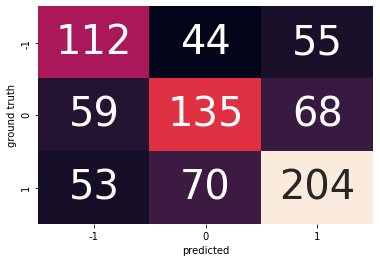

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

print(classification_report(test, test_preds))
sns.heatmap((confusion_matrix(test,test_preds)),annot=True,annot_kws={"size": 40},cbar=False,fmt='g',
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])

plt.xlabel('predicted')
plt.ylabel('ground truth')

##Neural Network

In [ ]:
from itertools import product
from sklearn.metrics import balanced_accuracy_score
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from matplotlib import pyplot as plt
#from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.constraints import maxnorm
import pickle 
#pd.set_option('display.max_colwidth', 2000) # To visualize full output
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
# Main code
from sklearn.model_selection import train_test_split
X = features
y = labels
param_grid = {  'Neurons':[8,16,32], 
               'batch_size':[16,32,64], 
               'epochs' : [20,30,50]} # Fix the epochs for now
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold()
test_inds = []
test_preds = []
test_score = []
test = []
for train_val_index, test_index in kf.split(X, y):
  X_train_val, X_test = X[train_val_index], X[test_index]
  y_train_val, y_test = y[train_val_index], y[test_index]
  model = Sequential([
    Dense(32, activation='relu', input_shape=(768,)), #input layer
    Dense(32, activation='relu'), ## hidden layer 
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42)

  history = model.fit(X_train_val, pd.get_dummies(y_train_val),
          batch_size=32, epochs=30,
          validation_data=(X_val, pd.get_dummies(y_val)))
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()
  plt.title('Loss Plots')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.title('Accuracy Plots')
  plt.show()
  res = model.predict(X_test)
  score = pd.DataFrame(res).max(axis =1)
  y_pred = pd.DataFrame(res, columns=[-1,0,1]).idxmax(axis=1)
  accuracy = f1_score(y_test, y_pred,average='macro')
  print(accuracy)
  test_inds.extend(test_index)
  test_preds.extend(y_pred)
  test_score.extend(score)
  test.extend(y_test)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
print(classification_report(test, test_preds))
sns.heatmap((confusion_matrix(test,test_preds)),annot=True,annot_kws={"size": 40},cbar=False,fmt='g',
            xticklabels=[0,1,2], yticklabels=[0,1,2])

plt.xlabel('predicted')
plt.ylabel('ground truth')
plt.show()

##TSNE plots

In [ ]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(features)
print(X_2d.shape)
tes = labels.to_list()

(701, 2)


In [ ]:
out_arr1 = np.argsort(X_2d, kind ='mergesort', axis = 0) 
print ("Output sorted array indices : ", out_arr1) 

range(0, 4)
<class 'range'>
[0 1 2]
<class 'numpy.ndarray'>


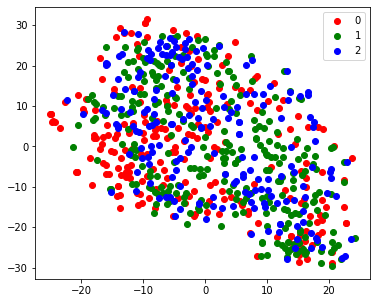

In [ ]:
target_ids = range(len(set(tes)))
colors = 'r', 'g', 'b'
classes = np.array([0,1,2])
print((target_ids))
print(type(target_ids))
print(classes)
print(type(classes))
from matplotlib import pyplot as plt
plt.figure(figsize = (6,5))

for i in range(len((tes))):
    if tes[i] == -1:
        tes[i] = 2
colors = 'r','g','b'
for i, c, label in zip(target_ids, colors, classes):
    plt.scatter(X_2d[labels == i, 0], X_2d[labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()
# Take the first 500 data points: it's hard to see 1500 points
X = digits.data[:500]
y = digits.target[:500]

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

X_2d = tsne.fit_transform(X)
#print(digits.target_names)
target_ids = range(len(digits.target_names))
print(target_ids)
print(type(target_ids))
print(digits.target_names)
print(type(digits.target_names))
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

range(0, 10)
<class 'range'>
[0 1 2 3 4 5 6 7 8 9]
<class 'numpy.ndarray'>
